In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import sklearn
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Chargement de la base Sentiment140 préprocessée 

In [3]:
df = pd.read_pickle(os.path.join("data", "sentiment140", "train.bz2"))
df

,sentiment,id,date,query_string,user,text
1325893,4,2015186894,Wed Jun 03 03:57:47 PDT 2009,NO_QUERY,Neta_Lifshitz,funny video worth listen get minute spare
346430,0,2016155708,Wed Jun 03 06:16:20 PDT 2009,NO_QUERY,beatty_2002,begin slow tire
863698,4,1677152268,Sat May 02 00:41:15 PDT 2009,NO_QUERY,Henwii,thought lose tshirt love yr ago tony find amp ...
734981,0,2264677911,Sun Jun 21 04:37:03 PDT 2009,NO_QUERY,DiscoverNicole,still buzz last night im post gig depression
1265463,4,1999454361,Mon Jun 01 20:14:46 PDT 2009,NO_QUERY,crisbeee,welcome back twitterverse r u darling hope u w...
...,...,...,...,...,...,...
758314,0,2295685410,Tue Jun 23 08:14:45 PDT 2009,NO_QUERY,polarna10,hate color green envy
936279,4,1792961448,Thu May 14 00:51:23 PDT 2009,NO_QUERY,Crichton_Kicks,flik ah yeah suppose long mind lot pringles co...
1173397,4,1980758885,Sun May 31 07:36:01 PDT 2009,NO_QUERY,serenawet,blast last night guy thanks much
883116,4,1686075988,Sun May 03 03:37:46 PDT 2009,NO_QUERY,MizSadittyFancy,ummmm sum egg white turkey bacon


array([[<AxesSubplot:title={'center':'sentiment'}>]], dtype=object)

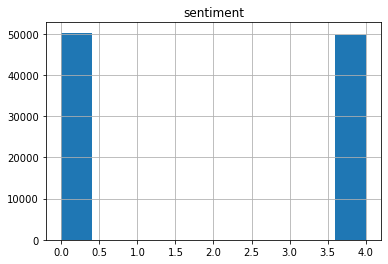

In [4]:
df.hist("sentiment")

In [5]:
df.sentiment = df.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')

# Term frequency

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(df.text)

neg_matrix = vectorizer.transform(df[df.sentiment == 'Negative'].text)
pos_matrix = vectorizer.transform(df[df.sentiment == 'Positive'].text)

In [7]:
print(df[df.sentiment == 'Negative'].iloc[1].text)
print(neg_matrix[1])
liste = vectorizer.get_feature_names()
print([liste[i] for i in neg_matrix[1].tocoo().col])

still buzz last night im post gig depression
  (0, 6052)	1
  (0, 10306)	1
  (0, 16055)	1
  (0, 19659)	1
  (0, 22944)	1
  (0, 28207)	1
  (0, 31849)	1
  (0, 38782)	1
['buzz', 'depression', 'gig', 'im', 'last', 'night', 'post', 'still']


In [8]:
neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],
                            columns=vectorizer.get_feature_names()
                           ).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', 
                         ascending=False
                        ).iloc[:10]

,negative,positive,total
get,6313,4916,11229
go,6093,4234,10327
day,3262,3563,6825
good,2053,3995,6048
work,3757,1791,5548
like,2580,2450,5030
love,1230,3472,4702
quot,1696,2950,4646
today,2439,1781,4220
time,2046,2165,4211


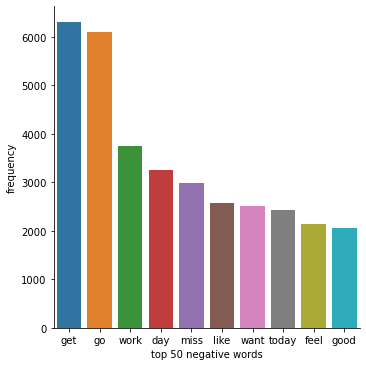

In [9]:
df1 = term_freq_df.sort_values(by='negative', ascending=False).head(10)
g = sns.catplot(x='index', y="negative", kind='bar', data=df1.reset_index())
g.set_axis_labels('top 50 negative words', 'frequency')
plt.show()

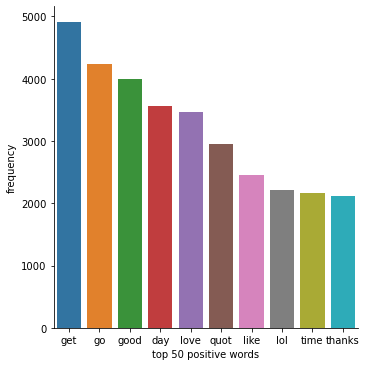

In [10]:
df2 = term_freq_df.sort_values(by='positive', ascending=False).head(10)
g = sns.catplot(x='index', y="positive", kind='bar', data=df2.reset_index())
g.set_axis_labels('top 50 positive words', 'frequency')
plt.show()

# Word cloud

In [31]:
positive_text = " ".join(df[df.sentiment == "Positive"].text.to_numpy().tolist())
negative_text = " ".join(df[df.sentiment == "Negative"].text.to_numpy().tolist())

positive_cloud = WordCloud(stopwords=['get', 'go'], max_words=50, background_color="white").generate(positive_text)
negative_cloud = WordCloud(stopwords=['get', 'go'], max_words=50, background_color="white").generate(negative_text)

In [32]:
def show_word_cloud(cloud, title):
    plt.figure(figsize = (16, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show();

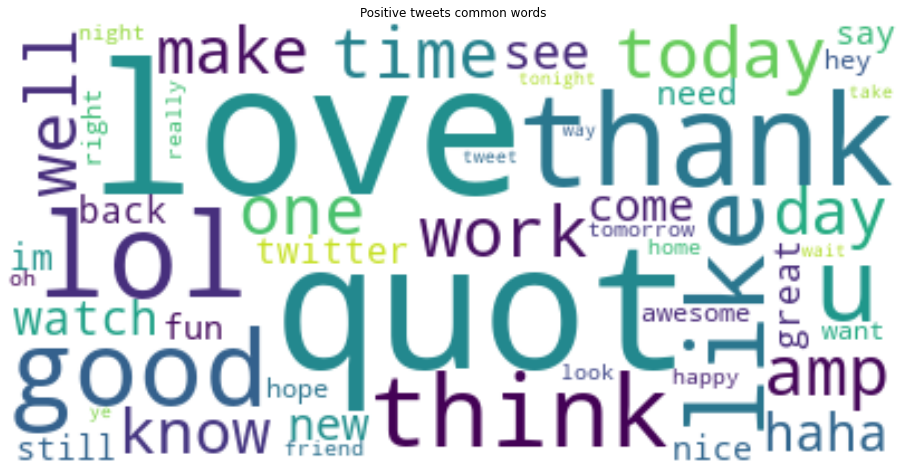

In [33]:
show_word_cloud(positive_cloud, "Positive tweets common words")

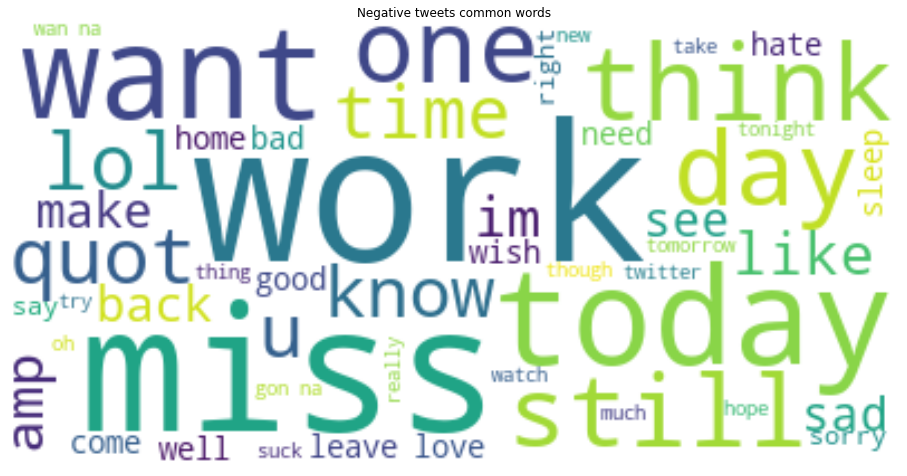

In [34]:
show_word_cloud(negative_cloud, "Negative tweets common words")